# Higgs Boson - ML Challenge

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from implementation import *
from model_helpers import *
from data_helpers import *

import warnings
warnings.simplefilter("ignore")

%load_ext autoreload
%autoreload 2

## Load the dataset

In [2]:
paths = { 
    'train' : 'data/train.csv',
     'test' : 'data/test.csv',
     'submission' : 'data/sample-submission.csv'
        }
N = 4

y_tr, tx_tr, ids_tr = load_csv_data(paths['train'], sub_sample=False)
y_te, tx_te, ids_te = load_csv_data(paths['test'])

In [3]:
len_test = len(y_te)

y_tr = y_tr[:, np.newaxis]
y_pred = np.zeros(len_test)

## Divide into 4 different subsets depending on jet value

In [4]:
mask_tr = get_mask(tx_tr)
mask_te = get_mask(tx_te)

x_tr_subsamples = []
y_tr_subsamples = []

x_te_subsamples = []

for i in range(N):
    x_tr_subsamples.append(tx_tr[mask_tr[i]])
    y_tr_subsamples.append(y_tr[mask_tr[i]])
    x_te_subsamples.append(tx_te[mask_te[i]])

In [5]:
for i in range(N):
    print(f'Dimension of subsample {i}: {len(x_tr_subsamples[i])}')

Dimension of subsample 0: 99913
Dimension of subsample 1: 77544
Dimension of subsample 2: 50379
Dimension of subsample 3: 22164


## Process the dataset

In [6]:
for j in range(N):
    x_tr_subsamples[j], x_te_subsamples[j] = pre_processing(x_tr_subsamples[j], x_te_subsamples[j], j)

## Cross Validation

In [33]:
def cross_validation(y, x, k_indices, k, lambda_, degree, gamma, function, max_iters=500):
    """
    Return the loss of ridge regression for a fold corresponding to k_indices
    
    Args:
        y:          shape=(N, 1)
        x:          shape=(N, D)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold
        lambda_:    scalar, used by ridge regression
        degree:     scalar, used by build poly
        gamma:      scalar, stepsize

    Returns:
        test loss: probability of predicting correct values
    """
    
    train_id = np.delete(k_indices, k, axis=0).ravel()
    test_id = k_indices[k]
    
    x_tr, y_tr = x[train_id], y[train_id]
    x_te, y_te = x[test_id], y[test_id]
    
    x_tr, x_te = build_poly(x_tr, degree), build_poly(x_te, degree)
    
    initial_w = np.zeros((x_tr.shape[1], 1))
    
    
    if function == 'RidgeRegression':
        
        w, _ = ridge_regression(y_tr, x_tr, lambda_)

    elif function == 'LeastSquares':
        
        w, _ = least_squares(y_tr, x_tr)
        
    elif function == 'LogisticRegression':
        
        w, _ = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
        
    elif function == 'RegLogisticRegression':
        
        w, _ = reg_logistic_regression(y_tr, x_tr, lambda_, initial_w, max_iters, gamma)
    
    
    return (y_tr == predict_labels(x_tr, w)).mean(), (y_te == predict_labels(x_te, w)).mean()

In [45]:
def cross_validation_grid_search(txs, ys, func):
    """
    Runs cross validation on the data with different values of hyperparameters to compare accuracy
    
    Args:
        txs: subsets of train dataset
        ys:  labels of the different subsets
        func: string, types of function
    """
    
    # Hyperparameters
    k_fold = 4
    seed = 100
    
    # Lambda: regularization parameter
    lambdas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    
    # Degree: feature augmentation
    degrees = range(1,11,1)
    
    # Gamma: stepsize
    #gammas = [1e-6, 1e-5, 1e-4, 1e-3]
    
    # split data in k fold
    k_indices = []
    for i in range(len(txs)):
        k_indices.append(build_k_indices(ys[i].shape[0], k_fold, seed))
        
    print(f"Function: {func}")
        
    best_tuple = [(-1, -1, -1, -1)]*N
    
    # cross validation
    
    #lambdas_acc = {}
    degrees_acc = {}
    
    for i in range(len(txs)):
        
        #lambdas_acc[i] = [0]*len(lambdas)
        degrees_acc[i] = [0]*len(degrees)
        
        max_acc_tr = 0
        max_acc_te = 0
        
        print(f"->Subset {i}:")
        
        for d_i, d in enumerate(degrees):
            max_local = 0
            for l in lambdas:
                for g in [0]:
                    
                    pred_pcts_tr = []
                    pred_pcts_te = []
                    
                    for k in range(k_fold):
                        pred_pct_tr, pred_pct_te = cross_validation(ys[i], txs[i], k_indices[i], k, l, d, g, func)
                        pred_pcts_tr.append(pred_pct_tr)
                        pred_pcts_te.append(pred_pct_te)

                    pct_tr = np.mean(pred_pcts_tr)
                    pct_te = np.mean(pred_pcts_te)
                    
                    if pct_tr > max_local:
                        max_local = pct_tr
                        #lambdas_acc[i][l_i] = pct_tr
                        degrees_acc[i][d_i] = pct_tr

                    if pct_te > max_acc_te:
                        max_acc_te = pct_te
                        best_tuple[i] = (l,d,g,pct_te)
                        print(f"- Set {i}/lamdba={l}/deg={d}/gamma={g}/Test acc={np.around(pct_te, 3)}/Train acc={np.around(pct_tr, 3)}")
                        
    
    return best_tuple, degrees_acc

In [46]:
functions = ['RidgeRegression', 'LeastSquares', 'LogisticRegression', 'RegLogisticRegression']

best_tuple = {}

for func in functions[0:1]:
    best_tuple[func], degrees_train = cross_validation_grid_search(x_tr_subsamples,y_tr_subsamples,func)

Function: RidgeRegression
->Subset 0:
- Set 0/lamdba=1e-07/deg=1/gamma=0/Test acc=0.845/Train acc=0.845
- Set 0/lamdba=0.001/deg=1/gamma=0/Test acc=0.845/Train acc=0.845
- Set 0/lamdba=1e-07/deg=2/gamma=0/Test acc=0.845/Train acc=0.846
- Set 0/lamdba=1e-07/deg=4/gamma=0/Test acc=0.846/Train acc=0.847
- Set 0/lamdba=1e-05/deg=4/gamma=0/Test acc=0.846/Train acc=0.847
- Set 0/lamdba=1e-07/deg=5/gamma=0/Test acc=0.846/Train acc=0.847
- Set 0/lamdba=1e-06/deg=5/gamma=0/Test acc=0.846/Train acc=0.847
- Set 0/lamdba=1e-05/deg=5/gamma=0/Test acc=0.846/Train acc=0.847
- Set 0/lamdba=0.0001/deg=5/gamma=0/Test acc=0.846/Train acc=0.847
- Set 0/lamdba=1e-07/deg=6/gamma=0/Test acc=0.846/Train acc=0.848
- Set 0/lamdba=1e-05/deg=6/gamma=0/Test acc=0.847/Train acc=0.848
- Set 0/lamdba=0.0001/deg=6/gamma=0/Test acc=0.847/Train acc=0.848
- Set 0/lamdba=0.001/deg=6/gamma=0/Test acc=0.847/Train acc=0.848
- Set 0/lamdba=0.001/deg=9/gamma=0/Test acc=0.847/Train acc=0.848
->Subset 1:
- Set 1/lamdba=1e-07/deg

In [47]:
degrees
lambdas
lambdas_train
degrees_train

{0: [0.845220460672058,
  0.8457542637521018,
  0.8457542637521018,
  0.8466817466036779,
  0.8473389916459817,
  0.8477259988790136,
  0.8478828035337764,
  0.8478060693410201,
  0.8478561133797742,
  0.8478360957642725],
 1: [0.8106408404690669,
  0.8117069018879604,
  0.8117069018879604,
  0.8148062175453077,
  0.8155455827229272,
  0.8156143608789848,
  0.8155971663399705,
  0.8155928677052168,
  0.8157906049038826,
  0.815794903538636],
 2: [0.8483404795934573,
  0.8494653538722143,
  0.8494653538722143,
  0.850894605896988,
  0.8513445556084909,
  0.8516687840770737,
  0.8520194801757451,
  0.8521650521412313,
  0.852806892170875,
  0.8529458472288391],
 3: [0.8453648559225171,
  0.8459062744390303,
  0.8459062744390303,
  0.8528544787342839,
  0.8539523551705468,
  0.8544486554773507,
  0.8543884978644047,
  0.8543884978644047,
  0.8548998375744451,
  0.8554111772844855]}

### Lambda analysis

In [39]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

In [40]:
l0 = np.array(lambdas[0])
l1 = np.array(lambdas[1])
l2 = np.array(lambdas[2])
l3 = np.array(lambdas[3])

ll = np.vstack((l0,l1,l2,l3))

l0t = np.array(lambdas_train[0])
l1t = np.array(lambdas_train[1])
l2t = np.array(lambdas_train[2])
l3t = np.array(lambdas_train[3])

llt = np.vstack((l0t,l1t,l2t,l3t))

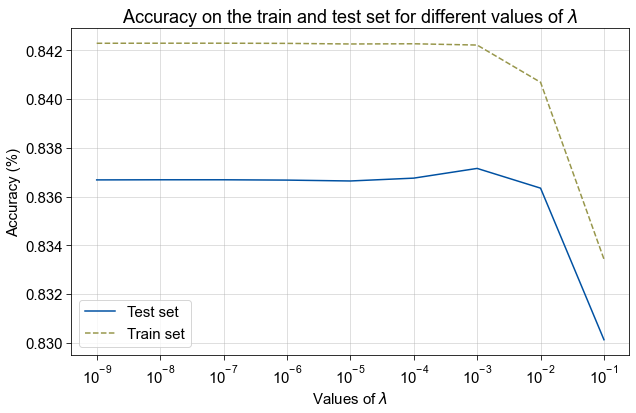

In [42]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']
params = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

ax.set_xscale('log')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel(r'Values of $\lambda$')

#ax.plot(params, l0, color=colors[0], label='Subset with jet value 0', linestyle='--')
#ax.plot(params, l1, color=colors[1], label='Subset with jet value 1', linestyle='--')
#ax.plot(params, l2, color=colors[2], label='Subset with jet value 2', linestyle='--')
#ax.plot(params, l3, color=colors[3], label='Subset with jet value 3', linestyle='--')
ax.plot(params, np.mean(ll, axis=0), color=colors[0], label='Test set')

#ax.plot(params, l0t, color=colors[0], label='Subset with jet value 0', linestyle='--')
#ax.plot(params, l1t, color=colors[1], label='Subset with jet value 1', linestyle='--')
#ax.plot(params, l2t, color=colors[2], label='Subset with jet value 2', linestyle='--')
#ax.plot(params, l3t, color=colors[3], label='Subset with jet value 3', linestyle='--')
ax.plot(params, np.mean(llt, axis=0), color=colors[1], linestyle='--', label='Train set')

major_ticks = params
minor_ticks = np.arange(0, 1e-1, 100)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title(r'Accuracy on the train and test set for different values of $\lambda$')
ax.legend(loc=0, prop={'size': 15})

#plt.show()

fig.savefig('./report/traintest1.png', bbox_inches='tight')
#fig.savefig('./report/lambdas2.jpg', bbox_inches='tight')

### Degree analysis

In [48]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

In [49]:
d0 = np.array(degrees[0])
d1 = np.array(degrees[1])
d2 = np.array(degrees[2])
d3 = np.array(degrees[3])

dd = np.vstack((d0,d1,d2,d3))

d0t = np.array(degrees_train[0])
d1t = np.array(degrees_train[1])
d2t = np.array(degrees_train[2])
d3t = np.array(degrees_train[3])

ddt = np.vstack((d0t,d1t,d2t,d3t))

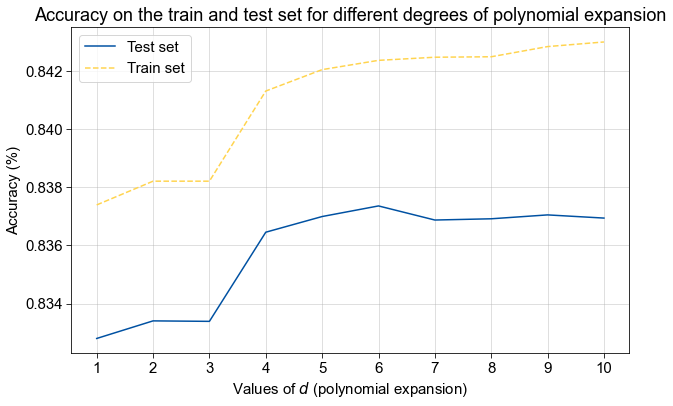

In [51]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']
params = range(1, 11, 1)

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel(r'Values of $d$ (polynomial expansion)')

#ax.plot(params, d0, color=colors[0], label='Subset with jet value 0', linestyle='--')
#ax.plot(params, d1, color=colors[1], label='Subset with jet value 1', linestyle='--')
#ax.plot(params, d2, color=colors[2], label='Subset with jet value 2', linestyle='--')
#ax.plot(params, d3, color=colors[3], label='Subset with jet value 3', linestyle='--')
ax.plot(params, np.mean(dd, axis=0), color=colors[0], label='Test set')

ax.plot(params, np.mean(ddt, axis=0), color=colors[2], label='Train set', linestyle='--')

major_ticks = params
minor_ticks = np.arange(0, 1e-1, 100)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_title(r'Accuracy on the train and test set for different degrees of polynomial expansion')
ax.legend(loc=0, prop={'size': 15})

#plt.show()

fig.savefig('./report/traintest2.png', bbox_inches='tight')
#fig.savefig('./report/degrees2.jpg', bbox_inches='tight')

## Train the model with the best parameters

In [ ]:
def train_model(txs, ys, params):
    """Trains the classifier model
    
    Args:
        txs: training data split into three subsets
        y: labels of training data split into three subsets
    
    Returns:
        ws: weights of each subsets.
    """
    
    ws = []
    
    for i in range(len(txs)):
        
        lambda_, degree, gamma, _ = params[i]
        x_poly = build_poly(txs[i], degree)
        initial_w = np.zeros((x_poly.shape[1], 1))
        
        ws.append(ridge_regression(ys[i], x_poly, lambda_=lambda_)[0])
        
    return ws

In [ ]:
chosen_function = 'RidgeRegression'

ws = train_model(x_tr_subsamples, y_tr_subsamples, best_tuple[chosen_function])

## Generate submission

In [ ]:
def generate_predictions(txs_te, ws, mask_test, y_pred, params):
    """Generate the predictions and save ouput
    
    Args:
        txs_te: subsets of test dataset
        ws: weights of the different subsets
    """
    
    for j in range(len(txs_te)):
        degree = params[j][1]
        y_pred[mask_test[j]] = [y[0] for y in predict_labels(build_poly(txs_te[j],degree), ws[j])]
            
    create_csv_submission(ids_te, y_pred, paths['submission'])

In [ ]:
generate_predictions(x_te_subsamples, ws, mask_te, y_pred, best_tuple[chosen_function])